In [1]:
#-Only look at DMI types with domain count= 1 and no 2nd required domain (from the same row) (1)
#-Read in the DMI types. Use dict to store SLiM : domain (with default use == 1).
#-Read in all domain matches from SMART output file and save as df ['uniprot', 'source', 'start', 'end', 'name']
#-For each line in elm interactions file:
# -check if this is a SLiM from (1):
# -if yes:
# --get required domain type from the dict
# --find all matches of this domain type in the 'domain protein'
# --compare these matches to the domain match from the elm interactions file:
# --for every match:
# ---if overlapping with original domain match:
# ----calculate JS
# ---else:
# ----calculate min. distance and make it a negative value
# ---take the match with the highest value (JS or min. distance)
# --add new start, new stop, domain ID and JS/min. distance to the DF
# --if not:
# ---add NaN to new columns in DF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# read in the curated DMI types
DMI_types = pd.read_csv('elm_interaction_domains_20200724_completed_final.tsv', sep= '\t')
print(DMI_types.shape)
DMI_types.head()

(416, 15)


,ELM ID,ELM name,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name,domain count,Default use,interaction domain ID,Interaction Domain Description.1,Interaction Domain Name.1,domain count.1,Default use 2,Coments,Notes,Unnamed: 14
0,ELME000321,CLV_C14_Caspase3-7,PF00656,Peptidase_C14,Caspase domain,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ELME000321,CLV_C14_Caspase3-7,SM00115,CASc,CASc,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ELME000172,CLV_MEL_PAP_1,PF00089,Trypsin,Trypsin,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ELME000172,CLV_MEL_PAP_1,SM00020,Tryp_SPc,Trypsin-like serine protease,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ELME000102,CLV_NRD_NRD_1,PF00675,Peptidase_M16,Insulinase (Peptidase family M16),1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
DMI_types_sel = DMI_types.loc[(DMI_types['Default use'] == 1) & (DMI_types['interaction domain ID'].isnull())]
DMI_types_sel.shape

(291, 15)

In [140]:
# read in the DMI instances
#elm_interactions= pd.read_csv('elm_interactions_200929_JL.tsv', sep= '\t')
elm_interactions= pd.read_csv('slim_matches_checked.tsv', sep= '\t')
#elm_interactions.drop(columns= ['Unnamed: 13', 'AffinityMin', 'AffinityMax', 'PMID', 'taxonomyElm', 'taxonomyDomain'], 
#                      inplace= True)

In [141]:
#Set up the new columns for the domain matches that will need to be filled later.
elm_interactions['DomainID']= float("NaN")
elm_interactions['DomainHMM']= float("NaN")
elm_interactions['StartDomain_new']= float("NaN")
elm_interactions['StopDomain_new']= float("NaN")
elm_interactions['Source']= float("NaN")
elm_interactions['Jaccard_distance']= float("NaN")
elm_interactions.head()

,Elm,Domain,interactorElm,interactorDomain,StartElm,StopElm,StartDomain,StopDomain,StartElm_new,StopElm_new,DomainID,DomainHMM,StartDomain_new,StopDomain_new,Source,Jaccard_distance
0,LIG_CID_NIM_1,IPR006569,P53632,P53617,574,583,1,153,574.0,583.0,NaN,NaN,NaN,NaN,NaN,NaN
1,LIG_WD40_WDR5_VDV_1,IPR017986,Q8BX09,P61965,374,377,33,331,374.0,377.0,NaN,NaN,NaN,NaN,NaN,NaN
2,LIG_WD40_WDR5_WIN_1,IPR017986,O14686,P61964,5338,5344,33,331,5338.0,5344.0,NaN,NaN,NaN,NaN,NaN,NaN
3,LIG_WD40_WDR5_WIN_1,IPR017986,O15047,P61964,1493,1499,33,331,1493.0,1499.0,NaN,NaN,NaN,NaN,NaN,NaN
4,LIG_WD40_WDR5_WIN_1,IPR017986,Q03164,P61964,3763,3769,33,331,3763.0,3769.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# write out the uniprot IDs from the domain proteins as input for the SMART DB to get the domain matches
target = open('domain_protein_uniprot_IDs.txt','w')
for d in set(elm_interactions['interactorDomain']):
    target.write(d + '\n')
target.close()

In [8]:
# read in the domain match information from SMART DB
file= open('smart_result_all_uniprot_domain.txt', 'r')
lines = [line[:-1] for line in file]
file.close()

all_domain_matches_dict= {}
for line in lines: 
    if line == '-- SMART RESULTS TEXTFORMAT --':
        uniprot= []
    elif line == '':
        continue
    else:
        j= line.split()
        if j[0] == 'USER_PROTEIN_ID':
            for k in j[2:len(j)]:
                uniprot.append(k)
        elif j[0] == 'DOMAIN=':
            domain= j[1]
        elif j[0] == 'START=':
            start= j[1]
        elif j[0] == 'END=':
            end= j[1]
        elif j[0] == 'EVALUE=':
            evalue= j[1]
        elif j[0] == 'TYPE=':
            if j[1] == 'INTRINSIC':
                continue
            else:
                domain_type= j[1]
            for prot in uniprot:
                if prot not in all_domain_matches_dict:
                    all_domain_matches_dict[prot]= []
                all_domain_matches_dict[prot].append((domain, start, end, domain_type, evalue))


In [9]:
#Create a function that calculates jaccard similarity using set functions.
def jaccard_similarity(start, stop, start_new, stop_new):

    A = set(range(start, stop+1))
    B = set(range(start_new, stop_new+1))
    intersection = len(set.intersection(A,B))
    union = len(set.union(A,B))

    if intersection == 0:
        if start_new > stop:
            return -(start_new - stop)
        else:
            return -(start - stop_new)
    else:
        return intersection/union

In [142]:
#-For each line in elm interactions file:
for ind, r in elm_interactions.iterrows():
    slim = r['Elm']
    JS_list = []
# -check if this is a SLiM from filtered df:
# -if yes:
# --get required domain type from the dict
# --find all matches of this domain type in the 'domain protein'
    if slim in list(DMI_types_sel['ELM name']):
        sub_DMI_list = DMI_types_sel.loc[DMI_types_sel['ELM name'] == slim]
        DMI_domains = list(sub_DMI_list['Interaction Domain Description'])
        DMI_HMMs = list(sub_DMI_list['Interaction Domain Id'])
        new_matches = all_domain_matches_dict[r['interactorDomain']]
        selected_matches = []
        old_start = r['StartDomain']
        old_stop = r['StopDomain']
# --compare these matches to the domain match from the elm interactions file:
# --for every match:
# ---if overlapping with original domain match:
# ----calculate JS
# ---else:
# ----calculate min. distance and make it a negative value
        for match in new_matches:
            for d, domain in enumerate(DMI_domains):
                if domain == match[0]:
                    if DMI_HMMs[d][:2] == match[3][:2]: 
                        selected_matches.append(match)
        for match in selected_matches:
            JS_list.append(jaccard_similarity(old_start, old_stop, int(match[1]), int(match[2])))
        if len(selected_matches) > 0:
            max_JS_ind = JS_list.index(max(JS_list))
            max_JS = JS_list[max_JS_ind]
            best_match = selected_matches[max_JS_ind]
            HMM = DMI_HMMs[DMI_domains.index(best_match[0])]
            elm_interactions.loc[ind, ['DomainID']]= best_match[0]
            elm_interactions.loc[ind, ['DomainHMM']]= HMM
            elm_interactions.loc[ind, ['StartDomain_new']] = best_match[1]
            elm_interactions.loc[ind, ['StopDomain_new']]= best_match[2]
            elm_interactions.loc[ind, ['Source']]= best_match[3]
            elm_interactions.loc[ind, ['Jaccard_distance']]= max_JS
        elif len(selected_matches) == 0:
            elm_interactions.loc[ind, ['DomainID']]= 'No match'
            elm_interactions.loc[ind, ['DomainHMM']]= 'No match'
            elm_interactions.loc[ind, ['StartDomain_new']] = 'No match'
            elm_interactions.loc[ind, ['StopDomain_new']]= 'No match'
            elm_interactions.loc[ind, ['Source']]= 'No match'
            elm_interactions.loc[ind, ['Jaccard_distance']]= float("NaN")
# --if not:
# ---leave the new columns in as NaN
    else:
        continue

In [143]:
# how many DMI instances have a mapped domain match, for how many we did not find a match, and how many have not been 
# checked yet?
print(elm_interactions.shape)
print(elm_interactions.loc[elm_interactions['DomainID'].notnull() & (elm_interactions['DomainID'] != 'No match')].shape)
print(elm_interactions.loc[elm_interactions['DomainID'] == 'No match'].shape)
print(elm_interactions.loc[elm_interactions['DomainID'].isnull()].shape)

(1540, 16)
(1472, 16)
(7, 16)
(61, 16)


In [144]:
# look at the 7 DMI instances for which we could not find a match
elm_interactions.loc[elm_interactions['DomainID'] == 'No match']

,Elm,Domain,interactorElm,interactorDomain,StartElm,StopElm,StartDomain,StopDomain,StartElm_new,StopElm_new,DomainID,DomainHMM,StartDomain_new,StopDomain_new,Source,Jaccard_distance
537,MOD_NEK2_1,PF00069,P40460,P22209,198,203,25,343,198.0,203.0,No match,No match,No match,No match,No match,NaN
598,LIG_14-3-3_CanoR_1,PF00244,B7UM99,Q3YBA8,54,58,6,53,54.0,58.0,No match,No match,No match,No match,No match,NaN
1004,LIG_MYND_1,PF01753,P03255,Q15326,113,117,563,598,113.0,117.0,No match,No match,No match,No match,No match,NaN
1005,LIG_MYND_1,PF01753,P12978,Q15326,383,387,563,598,383.0,387.0,No match,No match,No match,No match,No match,NaN
1006,LIG_MYND_1,PF01753,P12978,Q15326,437,441,563,598,437.0,441.0,No match,No match,No match,No match,No match,NaN
1008,LIG_MYND_1,PF01753,Q8IWI9,Q15326,2948,2952,563,598,NaN,NaN,No match,No match,No match,No match,No match,NaN
1009,LIG_MYND_1,PF01753,Q8IWI9,Q15326,2973,2977,563,598,NaN,NaN,No match,No match,No match,No match,No match,NaN


In [145]:
# the LIG_MYND_1 DMI with domain protein Q15326 has a match of the PF01753 domain that seems to be below the SMART 
# E-value cutoff
# PFAM shows that match as insignificant with an E-value of 0.016
# we will add this match manually to the table
elm_interactions.loc[(elm_interactions['Elm'] == 'LIG_MYND_1') & 
                     (elm_interactions['interactorDomain'] == 'Q15326'),
                     ['DomainID','DomainHMM','StartDomain_new','StopDomain_new','Source','Jaccard_distance']] = \
                ['zf-MYND','PF01753',563,598,'PFAM',1]

In [146]:
# the MOD_NEK2_1 DMI with domain protein P22209 has a match with the SMART domain SM00220 but probably doesn't hit 
# the significance cutoff of SMART, InterProScan reports it with exact the same start and end like the PFAM match 
# in the elm_interactions file
# we will add this match manually to the table
elm_interactions.loc[(elm_interactions['Elm'] == 'MOD_NEK2_1') & 
                     (elm_interactions['interactorDomain'] == 'P22209'),
                     ['DomainID','DomainHMM','StartDomain_new','StopDomain_new','Source','Jaccard_distance']] = \
                ['S_TKc','SM00220',25,343,'SMART',1]

In [147]:
# the remaining DMI with no match is LIG_14-3-3_CanoR_1 with domain protein Q3YBA8, not even InterProScan reports a 
# match with SMART HMM for the 14-3-3 domain
# so, for now we will leave this DMI as is, with no match

In [148]:
elm_interactions.loc[elm_interactions['DomainID'] == 'No match']

,Elm,Domain,interactorElm,interactorDomain,StartElm,StopElm,StartDomain,StopDomain,StartElm_new,StopElm_new,DomainID,DomainHMM,StartDomain_new,StopDomain_new,Source,Jaccard_distance
598,LIG_14-3-3_CanoR_1,PF00244,B7UM99,Q3YBA8,54,58,6,53,54.0,58.0,No match,No match,No match,No match,No match,NaN


In [149]:
# look at the SLiM types of the remaining DMI instances that we haven't checked yet because their DMI annotation is more complicated
elm_interactions.loc[elm_interactions['DomainID'].isnull()].head(20)
elm_interactions.loc[elm_interactions['DomainID'].isnull(),'Elm'].unique()
DMI_types.loc[DMI_types['ELM name'].isin(elm_interactions.loc[elm_interactions['DomainID'].isnull(),'Elm'].unique()) & (DMI_types['Default use'] == 1)]

,ELM ID,ELM name,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name,domain count,Default use,interaction domain ID,Interaction Domain Description.1,Interaction Domain Name.1,domain count.1,Default use 2,Coments,Notes,Unnamed: 14
211,ELME000385,LIG_Mtr4_Air2_1,PF00271,Helicase_C,Helicase_C domain,1,1,PF08148,DSHCT,DSHCT domain,1.0,0.0,ELM: ELM indicates PF00270 but after checking ...,Only in fungi.,NaN
212,ELME000385,LIG_Mtr4_Air2_1,PF00271,Helicase_C,Helicase_C domain,1,1,SM01142,DSHCT,DSHCT domain,1.0,1.0,ELM: ELM indicates PF00270 but after checking ...,Only in fungi.,NaN
231,ELME000475,LIG_PCNA_APIM_2,PF02747,PCNA_C,"Proliferating cell nuclear antigen, C-terminal...",1,1,PF00705,PCNA_N,"Proliferating cell nuclear antigen, N-terminal...",1.0,1.0,NaN,NaN,NaN
232,ELME000140,LIG_PCNA_PIPBox_1,PF02747,PCNA_C,"Proliferating cell nuclear antigen, C-terminal...",1,1,PF00705,PCNA_N,"Proliferating cell nuclear antigen, N-terminal...",1.0,1.0,NaN,NaN,NaN
233,ELME000483,LIG_PCNA_TLS_4,PF02747,PCNA_C,"Proliferating cell nuclear antigen, C-terminal...",1,1,PF00705,PCNA_N,"Proliferating cell nuclear antigen, N-terminal...",1.0,1.0,NaN,NaN,NaN
234,ELME000482,LIG_PCNA_yPIPBox_3,PF02747,PCNA_C,"Proliferating cell nuclear antigen, C-terminal...",1,1,PF00705,PCNA_N,"Proliferating cell nuclear antigen, N-terminal...",1.0,1.0,NaN,Only in fungi.,NaN
264,ELME000301,LIG_Rb_pABgroove_1,PF01857,RB_B,Retinoblastoma-associated protein B domain,1,1,PF01858,RB_A,Retinoblastoma-associated protein A domain,1.0,1.0,NaN,NaN,NaN
306,ELME000359,LIG_SUFU_1,PF05076,SUFU,Suppressor of fused protein (SUFU),1,1,PF12470,SUFU_C,Suppressor of Fused Gli/Ci N terminal binding ...,1.0,1.0,NaN,NaN,NaN
357,ELME000334,MOD_LATS_1,SM00220,S_TKc,Ser/Thr Protein kinase domain,1,1,SM00133,S_TK_X,Extension to Ser/Thr-type protein kinases,1.0,1.0,NaN,NaN,NaN


In [150]:
# we decided that if two different domains in a protein are required to recognize a SLiM that we should also request 
# that both domains have matches in this protein
# so we should try to find and annotate both domain matches for these DMI instances
# we have to change the elm interactions file to accomodate two domain matches in a row, two old ones and two new ones
# we have to search the elm interactions for instances where two domain matches have been saved in separate lines and 
# correct this to the new output format

In [151]:
elm_interactions.head(2)

,Elm,Domain,interactorElm,interactorDomain,StartElm,StopElm,StartDomain,StopDomain,StartElm_new,StopElm_new,DomainID,DomainHMM,StartDomain_new,StopDomain_new,Source,Jaccard_distance
0,LIG_CID_NIM_1,IPR006569,P53632,P53617,574,583,1,153,574.0,583.0,RPR,SM00582,9,150,SMART,0.928105
1,LIG_WD40_WDR5_VDV_1,IPR017986,Q8BX09,P61965,374,377,33,331,374.0,377.0,WD40,SM00320,245,287,SMART,0.143813


In [152]:
# rename existing column names to allow for two old and two new domain matches to be annotated
elm_interactions.rename(columns={'Domain':'HMMOld1','StartDomain':'StartDomainOld1','StopDomain':'StopDomainOld1',
                                'DomainID':'DomainNameNew1','DomainHMM':'HMMNew1','StartDomain_new':'StartDomainNew1',
                                'StopDomain_new':'StopDomainNew1','Source':'DomainSource1',
                                 'Jaccard_distance':'JaccardDistance1'},
                        inplace=True)
elm_interactions.head(2)

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,StartElm_new,StopElm_new,DomainNameNew1,HMMNew1,StartDomainNew1,StopDomainNew1,DomainSource1,JaccardDistance1
0,LIG_CID_NIM_1,IPR006569,P53632,P53617,574,583,1,153,574.0,583.0,RPR,SM00582,9,150,SMART,0.928105
1,LIG_WD40_WDR5_VDV_1,IPR017986,Q8BX09,P61965,374,377,33,331,374.0,377.0,WD40,SM00320,245,287,SMART,0.143813


In [153]:
# add columns to elm interactions file to deal with multiple required matches of different domains
elm_interactions['HMMOld2'] = float('NaN')
elm_interactions['StartDomainOld2'] = float('NaN')
elm_interactions['StopDomainOld2'] = float('NaN')
elm_interactions['DomainNameNew2'] = float('NaN')
elm_interactions['HMMNew2'] = float('NaN')
elm_interactions['StartDomainNew2'] = float('NaN')
elm_interactions['StopDomainNew2'] = float('NaN')
elm_interactions['DomainSource2'] = float('NaN')
elm_interactions['JaccardDistance2'] = float('NaN')

In [154]:
# find all entries in the elm interactions where two domain matches have been saved in separate lines and 
# correct this to the new output format
# check each SLiM type
# LIG_Mtr4_Air2_1 -> just one entry per DMI instance
# LIG_PCNA_APIM_2 -> just one entry per DMI instance
# LIG_PCNA_PIPBox_1 -> just one entry per DMI instance
# LIG_PCNA_TLS_4 -> just one entry per DMI instance
# LIG_PCNA_yPIPBox_3 -> just one entry per DMI instance
# MOD_LATS_1 -> just one entry per DMI instance
# LIG_Rb_pABgroove_1 -> removed 3 entries and added them as 2nd old domain entry
elm_interactions.loc[(elm_interactions['Elm'] == 'LIG_Rb_pABgroove_1') & 
                     (elm_interactions['HMMOld1'] == 'PF01857'), 
                     ['HMMOld2','StartDomainOld2','StopDomainOld2']] = ['PF01858',373,573]
elm_interactions.drop(elm_interactions.loc[(elm_interactions['Elm'] == 'LIG_Rb_pABgroove_1') & 
                                           (elm_interactions['HMMOld1'] == 'PF01858')].index,inplace=True)

# LIG_SUFU_1 -> removed 5 entries and added them as 2nd old domain entry
elm_interactions.loc[(elm_interactions['Elm'] == 'LIG_SUFU_1') & 
                     (elm_interactions['HMMOld1'] == 'PF05076') &
                     (elm_interactions['interactorDomain'] == 'Q9UMX1'), 
                     ['HMMOld2','StartDomainOld2','StopDomainOld2']] = ['PF12470',252,473]
elm_interactions.loc[(elm_interactions['Elm'] == 'LIG_SUFU_1') & 
                     (elm_interactions['HMMOld1'] == 'PF05076') &
                     (elm_interactions['interactorDomain'] == 'Q9VG38'), 
                     ['HMMOld2','StartDomainOld2','StopDomainOld2']] = ['PF12470',248,450]
elm_interactions.drop(elm_interactions.loc[(elm_interactions['Elm'] == 'LIG_SUFU_1') & 
                                           (elm_interactions['HMMOld1'] == 'PF12470')].index,inplace=True)


In [155]:
# find the best domain matches for the DMIs with two different domain matches
# there is two cases:
# two old domain matches available
# -> find matches for each new domain type -> determine best matches
# only one old domain match available
# -> find best match for this domain, for other domain type, if only one match in protein, add this one

In [156]:
DMI_types_sel2 = DMI_types.loc[(DMI_types['Default use'] == 1) & 
                               (DMI_types['interaction domain ID'].notnull()) & 
                               (DMI_types['Default use 2'] == 1)]
DMI_types_sel2.head(1)

,ELM ID,ELM name,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name,domain count,Default use,interaction domain ID,Interaction Domain Description.1,Interaction Domain Name.1,domain count.1,Default use 2,Coments,Notes,Unnamed: 14
31,ELME000355,DEG_Nend_Nbox_1,SM00396,ZnF_UBR1,ZnF_UBR1,1,1,PF02617,ClpS,ATP-dependent Clp protease adaptor protein ClpS,1.0,1.0,NaN,NaN,NaN


In [157]:
for ind, r in elm_interactions.iterrows():
    slim = r['Elm']
    JS_list1 = []
    JS_list2 = []
# -check if this is a SLiM from filtered df:
    if slim in list(DMI_types_sel2['ELM name']):
        sub_DMI_list = DMI_types_sel2.loc[DMI_types_sel2['ELM name'] == slim]
        new_matches = all_domain_matches_dict[r['interactorDomain']]
        selected_matches = []
        selected_matches2 = []
        old_start1 = r['StartDomainOld1']
        old_stop1 = r['StopDomainOld1']
        DMI_domains = list(sub_DMI_list['Interaction Domain Description']) + list(sub_DMI_list['Interaction Domain Description.1'])
        DMI_HMMs = list(sub_DMI_list['Interaction Domain Id']) + list(sub_DMI_list['interaction domain ID'])

        # if this DMI has two old domain matches, find the best match to each of them
        if pd.notnull(r['StartDomainOld2']):
            old_start2 = r['StartDomainOld2']
            old_stop2 = r['StopDomainOld2']
            for match in new_matches:
                for d, domain in enumerate(DMI_domains):
                    if domain == match[0]:
                        if DMI_HMMs[d][:2] == match[3][:2]: 
                            selected_matches.append(match)
            for match in selected_matches:
                JS_list1.append(jaccard_similarity(old_start1, old_stop1, int(match[1]), int(match[2])))
                JS_list2.append(jaccard_similarity(int(old_start2), int(old_stop2), int(match[1]), int(match[2])))
            if len(selected_matches) > 0:
                # get best match for first old domain
                max_JS_ind = JS_list1.index(max(JS_list1))
                max_JS = JS_list1[max_JS_ind]
                best_match = selected_matches[max_JS_ind]
                HMM = DMI_HMMs[DMI_domains.index(best_match[0])]
                elm_interactions.loc[ind, ['DomainNameNew1']]= best_match[0]
                elm_interactions.loc[ind, ['HMMNew1']]= HMM
                elm_interactions.loc[ind, ['StartDomainNew1']] = best_match[1]
                elm_interactions.loc[ind, ['StopDomainNew1']]= best_match[2]
                elm_interactions.loc[ind, ['DomainSource1']]= best_match[3]
                elm_interactions.loc[ind, ['JaccardDistance1']]= max_JS
                # get best match for second old domain
                max_JS_ind = JS_list2.index(max(JS_list2))
                max_JS = JS_list2[max_JS_ind]
                best_match = selected_matches[max_JS_ind]
                HMM = DMI_HMMs[DMI_domains.index(best_match[0])]
                elm_interactions.loc[ind, ['DomainNameNew2']]= best_match[0]
                elm_interactions.loc[ind, ['HMMNew2']]= HMM
                elm_interactions.loc[ind, ['StartDomainNew2']] = best_match[1]
                elm_interactions.loc[ind, ['StopDomainNew2']]= best_match[2]
                elm_interactions.loc[ind, ['DomainSource2']]= best_match[3]
                elm_interactions.loc[ind, ['JaccardDistance2']]= max_JS
            elif len(selected_matches) == 0:
                elm_interactions.loc[ind, ['DomainNameNew1']]= 'No match'
                elm_interactions.loc[ind, ['HMMNew1']]= 'No match'
                elm_interactions.loc[ind, ['StartDomainNew1']] = 'No match'
                elm_interactions.loc[ind, ['StopDomainNew1']]= 'No match'
                elm_interactions.loc[ind, ['DomainSource1']]= 'No match'
                elm_interactions.loc[ind, ['JaccardDistance1']]= float("NaN")
                elm_interactions.loc[ind, ['DomainNameNew2']]= 'No match'
                elm_interactions.loc[ind, ['HMMNew2']]= 'No match'
                elm_interactions.loc[ind, ['StartDomainNew2']] = 'No match'
                elm_interactions.loc[ind, ['StopDomainNew2']]= 'No match'
                elm_interactions.loc[ind, ['DomainSource2']]= 'No match'
                elm_interactions.loc[ind, ['JaccardDistance2']]= float("NaN")
             
        # there is only one old domain match -> find the best match for this one, check whether for the other 
        # domain type, there is only one match in the protein, in which case, this one can be added
        else:
            # find best match for first old domain match
            for match in new_matches:
                for d, domain in enumerate(DMI_domains):
                    if domain == match[0]:
                        if DMI_HMMs[d][:2] == match[3][:2]: 
                            selected_matches.append(match)
            for match in selected_matches:
                JS_list1.append(jaccard_similarity(old_start1, old_stop1, int(match[1]), int(match[2])))
            if len(selected_matches) > 0:
                max_JS_ind = JS_list1.index(max(JS_list1))
                max_JS = JS_list1[max_JS_ind]
                best_match = selected_matches[max_JS_ind]
                HMM = DMI_HMMs[DMI_domains.index(best_match[0])]
                elm_interactions.loc[ind, ['DomainNameNew1']]= best_match[0]
                elm_interactions.loc[ind, ['HMMNew1']]= HMM
                elm_interactions.loc[ind, ['StartDomainNew1']] = best_match[1]
                elm_interactions.loc[ind, ['StopDomainNew1']]= best_match[2]
                elm_interactions.loc[ind, ['DomainSource1']]= best_match[3]
                elm_interactions.loc[ind, ['JaccardDistance1']]= max_JS

                # determine the domain type of the second domain
                DMI_domains2 = []
                DMI_HMMs2 = []
                for h, hmm in enumerate(DMI_HMMs):
                    if hmm != HMM:
                        DMI_domains2.append(DMI_domains[h])
                        DMI_HMMs2.append(hmm)
                # find matches for second domain type
                for match in new_matches:
                    for d, domain in enumerate(DMI_domains2):
                        if domain == match[0]:
                            if DMI_HMMs2[d][:2] == match[3][:2]: 
                                selected_matches2.append(match)
                                
                # if there is only one match, write into the table
                if len(selected_matches2) == 1:
                    elm_interactions.loc[ind, ['DomainNameNew2']]= selected_matches2[0][0]
                    elm_interactions.loc[ind, ['HMMNew2']]= DMI_HMMs2[DMI_domains2.index(selected_matches2[0][0])]
                    elm_interactions.loc[ind, ['StartDomainNew2']] = selected_matches2[0][1]
                    elm_interactions.loc[ind, ['StopDomainNew2']]= selected_matches2[0][2]
                    elm_interactions.loc[ind, ['DomainSource2']]= selected_matches2[0][3]
                    elm_interactions.loc[ind, ['JaccardDistance2']]= float('NaN')
                elif len(selected_matches2) == 0:
                    elm_interactions.loc[ind, ['DomainNameNew2']]= 'No match'
                    elm_interactions.loc[ind, ['HMMNew2']]= 'No match'
                    elm_interactions.loc[ind, ['StartDomainNew2']] = 'No match'
                    elm_interactions.loc[ind, ['StopDomainNew2']]= 'No match'
                    elm_interactions.loc[ind, ['DomainSource2']]= 'No match'
                    elm_interactions.loc[ind, ['JaccardDistance2']]= float("NaN")
                else:
                    elm_interactions.loc[ind, ['DomainNameNew2']]= 'Many matches'
                    elm_interactions.loc[ind, ['HMMNew2']]= 'Many matches'
                    elm_interactions.loc[ind, ['StartDomainNew2']] = 'Many matches'
                    elm_interactions.loc[ind, ['StopDomainNew2']]= 'Many matches'
                    elm_interactions.loc[ind, ['DomainSource2']]= 'Many matches'
                    elm_interactions.loc[ind, ['JaccardDistance2']]= float("NaN")

            elif len(selected_matches) == 0:
                elm_interactions.loc[ind, ['DomainNameNew1']]= 'No match'
                elm_interactions.loc[ind, ['HMMNew1']]= 'No match'
                elm_interactions.loc[ind, ['StartDomainNew1']] = 'No match'
                elm_interactions.loc[ind, ['StopDomainNew1']]= 'No match'
                elm_interactions.loc[ind, ['DomainSource1']]= 'No match'
                elm_interactions.loc[ind, ['JaccardDistance1']]= float("NaN")
                elm_interactions.loc[ind, ['DomainNameNew2']]= 'No match'
                elm_interactions.loc[ind, ['HMMNew2']]= 'No match'
                elm_interactions.loc[ind, ['StartDomainNew2']] = 'No match'
                elm_interactions.loc[ind, ['StopDomainNew2']]= 'No match'
                elm_interactions.loc[ind, ['DomainSource2']]= 'No match'
                elm_interactions.loc[ind, ['JaccardDistance2']]= float("NaN")


In [158]:
# I checked the following SLiM types to see whether the updated DMI instances for these SLiM types are correct
# LIG_Mtr4_Air2_1
# LIG_PCNA_APIM_2
# LIG_PCNA_PIPBox_1
# LIG_PCNA_TLS_4
# LIG_PCNA_yPIPBox_3
# MOD_LATS_1
# LIG_Rb_pABgroove_1
# LIG_SUFU_1
# looks all good
# for these SLiM types no single entry with "no match" or "Many matches" has been created

elm_interactions.loc[elm_interactions['Elm'] == 'LIG_Mtr4_Air2_1']

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,StartElm_new,StopElm_new,...,JaccardDistance1,HMMOld2,StartDomainOld2,StopDomainOld2,DomainNameNew2,HMMNew2,StartDomainNew2,StopDomainNew2,DomainSource2,JaccardDistance2
600,LIG_Mtr4_Air2_1,PF00270,P40507,P47047,55,59,151,302,55.0,59.0,...,-90.0,NaN,NaN,NaN,DSHCT,SM01142,896,1073,SMART,NaN
601,LIG_Mtr4_Air2_1,PF00270,Q12476,P47047,43,47,151,302,43.0,47.0,...,-90.0,NaN,NaN,NaN,DSHCT,SM01142,896,1073,SMART,NaN
602,LIG_Mtr4_Air2_1,PF00270,Q9P795,O14232,78,82,200,351,78.0,82.0,...,-88.0,NaN,NaN,NaN,DSHCT,SM01142,939,1117,SMART,NaN


In [159]:
elm_interactions.loc[elm_interactions['DomainNameNew2'] == 'Many matches']

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,StartElm_new,StopElm_new,...,JaccardDistance1,HMMOld2,StartDomainOld2,StopDomainOld2,DomainNameNew2,HMMNew2,StartDomainNew2,StopDomainNew2,DomainSource2,JaccardDistance2


(array([1.000e+01, 7.000e+00, 1.000e+00, 0.000e+00, 4.900e+01, 2.000e+01,
        2.000e+01, 3.000e+01, 1.430e+02, 1.191e+03]),
 array([0.03191489, 0.1287234 , 0.22553191, 0.32234043, 0.41914894,
        0.51595745, 0.61276596, 0.70957447, 0.80638298, 0.90319149,
        1.        ]),
 <a list of 10 Patch objects>)

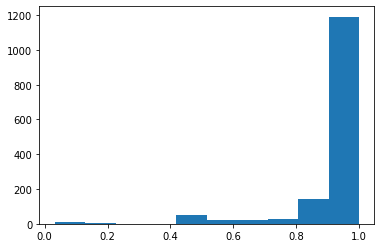

In [160]:
# Make a plot that shows the distribution of jaccard similarities, ignore the few second domain matches
plt.hist(elm_interactions.loc[elm_interactions['JaccardDistance1']>0,'JaccardDistance1'])

(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 51.]),
 array([-1808. , -1629.6, -1451.2, -1272.8, -1094.4,  -916. ,  -737.6,
         -559.2,  -380.8,  -202.4,   -24. ]),
 <a list of 10 Patch objects>)

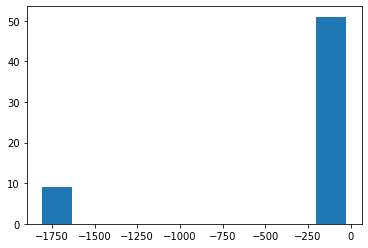

In [161]:
# Make a plot that shows the distribution of the distances when domain matches did not overlap, ignore the few second domain matches
plt.hist(elm_interactions.loc[(elm_interactions['JaccardDistance1']<0) & 
                              (elm_interactions['JaccardDistance1'].notnull()),'JaccardDistance1'])

In [162]:
# what are the DMIs that have such a distance between the old and new match?
elm_interactions.loc[(elm_interactions['JaccardDistance1'] < -1500) & 
                     (elm_interactions['JaccardDistance1'].notnull())]
# seems that the old match gives a wrong position -> in SMART the domain of the old match is situated at position 2374, 
# which brings it much closer to the new domain match

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,StartElm_new,StopElm_new,...,JaccardDistance1,HMMOld2,StartDomainOld2,StopDomainOld2,DomainNameNew2,HMMNew2,StartDomainNew2,StopDomainNew2,DomainSource2,JaccardDistance2
924,LIG_PAM2_1,PF00658,P23226,Q62671,234,246,499,571,234.0,246.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
928,LIG_PAM2_1,PF00658,P53804,Q62671,1205,1217,499,571,1205.0,1217.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
932,LIG_PAM2_1,PF00658,Q14106,Q62671,131,143,499,571,131.0,143.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933,LIG_PAM2_1,PF00658,Q14106,Q62671,251,263,499,571,251.0,263.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,LIG_PAM2_1,PF00658,Q14694,Q62671,81,93,499,571,81.0,93.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
943,LIG_PAM2_1,PF00658,Q8IYD1,Q62671,50,62,499,571,50.0,62.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
944,LIG_PAM2_1,PF00658,Q8IYD1,Q62671,59,71,499,571,59.0,71.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
949,LIG_PAM2_1,PF00658,Q99700,Q62671,912,924,499,571,912.0,924.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
953,LIG_PAM2_1,PF00658,Q9H074,Q62671,126,138,499,571,126.0,138.0,...,-1808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([12.,  0., 12.,  0.,  0.,  0., 15.,  0.,  0., 12.]),
 array([-197. , -179.7, -162.4, -145.1, -127.8, -110.5,  -93.2,  -75.9,
         -58.6,  -41.3,  -24. ]),
 <a list of 10 Patch objects>)

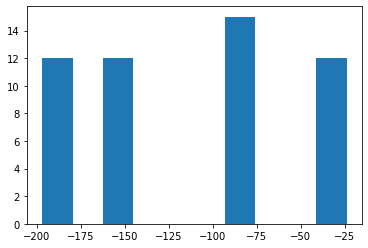

In [163]:
plt.hist(elm_interactions.loc[(elm_interactions['JaccardDistance1']<0) & 
                              (elm_interactions['JaccardDistance1']> -500) & 
                              (elm_interactions['JaccardDistance1'].notnull()),'JaccardDistance1'])

In [164]:
elm_interactions.loc[(elm_interactions['JaccardDistance1']<0) & 
                              (elm_interactions['JaccardDistance1']> -500) & 
                              (elm_interactions['JaccardDistance1'].notnull()),]
# there is a problem with the SLiM type LIG_HCF-1_HBM_1 and its DMI instances -> the repeats are in different lines
# there are also actually some uncertainties about the right HMMs, number of Kelch domains, etc

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,StartElm_new,StopElm_new,...,JaccardDistance1,HMMOld2,StartDomainOld2,StopDomainOld2,DomainNameNew2,HMMNew2,StartDomainNew2,StopDomainNew2,DomainSource2,JaccardDistance2
600,LIG_Mtr4_Air2_1,PF00270,P40507,P47047,55,59,151,302,55.0,59.0,...,-90.0,NaN,NaN,NaN,DSHCT,SM01142,896,1073,SMART,NaN
601,LIG_Mtr4_Air2_1,PF00270,Q12476,P47047,43,47,151,302,43.0,47.0,...,-90.0,NaN,NaN,NaN,DSHCT,SM01142,896,1073,SMART,NaN
602,LIG_Mtr4_Air2_1,PF00270,Q9P795,O14232,78,82,200,351,78.0,82.0,...,-88.0,NaN,NaN,NaN,DSHCT,SM01142,939,1117,SMART,NaN
1325,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,91,145,78.0,81.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1326,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,146,208,78.0,81.0,...,-79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1327,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,215,263,78.0,81.0,...,-148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1328,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,264,330,78.0,81.0,...,-197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,91,145,361.0,364.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1330,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,146,208,361.0,364.0,...,-79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1331,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,215,263,361.0,364.0,...,-148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
elm_interactions.loc[elm_interactions['Elm'] == 'LIG_HCF-1_HBM_1',
                     ['Elm','HMMOld1','interactorElm','interactorDomain','StartElm','StopElm','StartDomainOld1',\
                      'StopDomainOld1','DomainNameNew1','HMMNew1','StartDomainNew1','StopDomainNew1',\
                      'JaccardDistance1']]

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,DomainNameNew1,HMMNew1,StartDomainNew1,StopDomainNew1,JaccardDistance1
1325,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,91,145,Kelch_5,PF13854,29,67,-24.0
1326,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,146,208,Kelch_5,PF13854,29,67,-79.0
1327,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,215,263,Kelch_5,PF13854,29,67,-148.0
1328,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,264,330,Kelch_5,PF13854,29,67,-197.0
1329,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,91,145,Kelch_5,PF13854,29,67,-24.0
1330,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,146,208,Kelch_5,PF13854,29,67,-79.0
1331,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,215,263,Kelch_5,PF13854,29,67,-148.0
1332,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,264,330,Kelch_5,PF13854,29,67,-197.0
1333,LIG_HCF-1_HBM_1,PF13415,P08152,P51610,162,165,91,145,Kelch_5,PF13854,29,67,-24.0
1334,LIG_HCF-1_HBM_1,PF13415,P08152,P51610,162,165,146,208,Kelch_5,PF13854,29,67,-79.0


In [166]:
DMI_types.loc[DMI_types['ELM name'] == 'LIG_HCF-1_HBM_1',]

,ELM ID,ELM name,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name,domain count,Default use,interaction domain ID,Interaction Domain Description.1,Interaction Domain Name.1,domain count.1,Default use 2,Coments,Notes,Unnamed: 14
180,ELME000302,LIG_HCF-1_HBM_1,PF13854,Kelch_5,Kelch motif,4,1,NaN,NaN,NaN,NaN,NaN,The ELM page claims that the interacting domai...,Caution: The ELM says that it’s 6 repeats but ...,NaN


In [167]:
# check the elm_interactions entries for any occurrence of repeats that are entered as separate lines
# choose the repeat with the best match, if there are multiple, choose the first repeat
# get a unique DF with ELM, SLiM start, stop, domain ID, protein IDs
elm_interactions_unique = elm_interactions[['Elm','HMMOld1','interactorElm','interactorDomain',
                                                 'StartElm','StopElm']].drop_duplicates()
print(elm_interactions.shape)
print(elm_interactions_unique.shape)

(1532, 25)
(1417, 6)


In [168]:
# go through the unique DMIs, for each, search all occurrences in elm_interactions -> if multiple, find the row 
# to keep and delete the others
for i,row in elm_interactions_unique.iterrows():
    DMI_rows = elm_interactions.loc[(elm_interactions['Elm'] == row['Elm']) &
                                    (elm_interactions['HMMOld1'] == row['HMMOld1']) &
                                    (elm_interactions['interactorElm'] == row['interactorElm']) &
                                    (elm_interactions['interactorDomain'] == row['interactorDomain']) &
                                    (elm_interactions['StartElm'] == row['StartElm']) &
                                    (elm_interactions['StopElm'] == row['StopElm']),]
    if DMI_rows.shape[0] > 1:
        # check whether this DMI corresponds to a DMI type with domain count > 1
        if DMI_types.loc[(DMI_types['ELM name'] == row['Elm']) & 
                      (DMI_types['Default use'] == 1) & 
                      (DMI_types['domain count'] > 1),].shape[0] > 0:
            # find the value of the best domain overlap
            best_JC = DMI_rows['JaccardDistance1'].max()
            # if there is more than one row with that best domain overlap
            best_DMI_rows = DMI_rows.loc[DMI_rows['JaccardDistance1'] == best_JC,]
            if best_DMI_rows.shape[0] > 1:
                # choose the row with the first domain match in the protein sequence, delete all others
                first_start = best_DMI_rows['StartDomainOld1'].min()
                elm_interactions.drop(elm_interactions.loc[(elm_interactions['Elm'] == row['Elm']) &
                                                           (elm_interactions['HMMOld1'] == row['HMMOld1']) &
                                                           (elm_interactions['interactorElm'] == row['interactorElm']) &
                                                           (elm_interactions['interactorDomain'] == row['interactorDomain']) &
                                                           (elm_interactions['StartElm'] == row['StartElm']) &
                                                           (elm_interactions['StopElm'] == row['StopElm']) & 
                                                           (elm_interactions['StartDomainOld1'] > first_start),].index,
                                     inplace=True)
            else:
                # drop the lines that don't have the best JC score
                elm_interactions.drop(elm_interactions.loc[(elm_interactions['Elm'] == row['Elm']) &
                                                           (elm_interactions['HMMOld1'] == row['HMMOld1']) &
                                                           (elm_interactions['interactorElm'] == row['interactorElm']) &
                                                           (elm_interactions['interactorDomain'] == row['interactorDomain']) &
                                                           (elm_interactions['StartElm'] == row['StartElm']) &
                                                           (elm_interactions['StopElm'] == row['StopElm']) & 
                                                           (elm_interactions['JaccardDistance1'] < best_JC),].index,
                                     inplace=True)


In [169]:
print(elm_interactions.shape)

(1425, 25)


In [170]:
elm_interactions.loc[elm_interactions['Elm'] == 'LIG_HCF-1_HBM_1',
                     ['Elm','HMMOld1','interactorElm','interactorDomain','StartElm','StopElm','StartDomainOld1',\
                      'StopDomainOld1','DomainNameNew1','HMMNew1','StartDomainNew1','StopDomainNew1',\
                      'JaccardDistance1']]

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,DomainNameNew1,HMMNew1,StartDomainNew1,StopDomainNew1,JaccardDistance1
1325,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,91,145,Kelch_5,PF13854,29,67,-24.0
1329,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,91,145,Kelch_5,PF13854,29,67,-24.0
1333,LIG_HCF-1_HBM_1,PF13415,P08152,P51610,162,165,91,145,Kelch_5,PF13854,29,67,-24.0
1337,LIG_HCF-1_HBM_1,PF13415,P29747,P51610,64,67,91,145,Kelch_5,PF13854,29,67,-24.0
1341,LIG_HCF-1_HBM_1,PF13415,Q01094,P51610,97,100,91,145,Kelch_5,PF13854,29,67,-24.0
1345,LIG_HCF-1_HBM_1,PF13415,Q16254,P51610,389,392,91,145,Kelch_5,PF13854,29,67,-24.0
1349,LIG_HCF-1_HBM_1,PF13415,Q5VV67,P51610,1295,1298,91,145,Kelch_5,PF13854,29,67,-24.0
1353,LIG_HCF-1_HBM_1,PF13415,Q8WTV1,P51610,177,180,91,145,Kelch_5,PF13854,29,67,-24.0
1357,LIG_HCF-1_HBM_1,PF13415,Q9JJD0,P51610,234,237,91,145,Kelch_5,PF13854,29,67,-24.0
1361,LIG_HCF-1_HBM_1,PF13415,Q9NS37,P51610,303,306,91,145,Kelch_5,PF13854,29,67,-24.0


(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
 array([-90. , -83.4, -76.8, -70.2, -63.6, -57. , -50.4, -43.8, -37.2,
        -30.6, -24. ]),
 <a list of 10 Patch objects>)

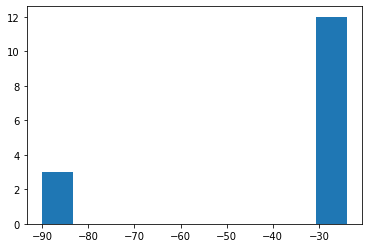

In [171]:
# check now again how many DMIs with a negative JC are left over
plt.hist(elm_interactions.loc[(elm_interactions['JaccardDistance1']<0) & 
                              (elm_interactions['JaccardDistance1']> -500) & 
                              (elm_interactions['JaccardDistance1'].notnull()),'JaccardDistance1'])

In [172]:
elm_interactions.loc[(elm_interactions['JaccardDistance1']<0) & 
                              (elm_interactions['JaccardDistance1']> -500) & 
                              (elm_interactions['JaccardDistance1'].notnull()),]

,Elm,HMMOld1,interactorElm,interactorDomain,StartElm,StopElm,StartDomainOld1,StopDomainOld1,StartElm_new,StopElm_new,...,JaccardDistance1,HMMOld2,StartDomainOld2,StopDomainOld2,DomainNameNew2,HMMNew2,StartDomainNew2,StopDomainNew2,DomainSource2,JaccardDistance2
600,LIG_Mtr4_Air2_1,PF00270,P40507,P47047,55,59,151,302,55.0,59.0,...,-90.0,NaN,NaN,NaN,DSHCT,SM01142,896,1073,SMART,NaN
601,LIG_Mtr4_Air2_1,PF00270,Q12476,P47047,43,47,151,302,43.0,47.0,...,-90.0,NaN,NaN,NaN,DSHCT,SM01142,896,1073,SMART,NaN
602,LIG_Mtr4_Air2_1,PF00270,Q9P795,O14232,78,82,200,351,78.0,82.0,...,-88.0,NaN,NaN,NaN,DSHCT,SM01142,939,1117,SMART,NaN
1325,LIG_HCF-1_HBM_1,PF13415,O43889,P51610,78,81,91,145,78.0,81.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,LIG_HCF-1_HBM_1,PF13415,P06492,P51610,361,364,91,145,361.0,364.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,LIG_HCF-1_HBM_1,PF13415,P08152,P51610,162,165,91,145,162.0,165.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337,LIG_HCF-1_HBM_1,PF13415,P29747,P51610,64,67,91,145,64.0,67.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341,LIG_HCF-1_HBM_1,PF13415,Q01094,P51610,97,100,91,145,97.0,100.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1345,LIG_HCF-1_HBM_1,PF13415,Q16254,P51610,389,392,91,145,389.0,392.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1349,LIG_HCF-1_HBM_1,PF13415,Q5VV67,P51610,1295,1298,91,145,1295.0,1298.0,...,-24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
target = 'elm_interactions_all_checked_20201109_KL.tsv'
elm_interactions.to_csv(target,sep='\t')

In [189]:
# plot the fraction of SLiM types for each SLiM class that has at least one DMI instance
# add a column to elm_interactions about the SLiM class
elm_interactions['SLiMClass'] = elm_interactions['Elm'].str.slice(stop=3)

# filter elm_interactions to those DMIs that I can count
elm_ints_mapped = elm_interactions.loc[(elm_interactions['StartElm_new'].notnull()) & 
                                       (elm_interactions['StartDomainNew1']).notnull(),]
print(elm_interactions.shape)
print(elm_ints_mapped.shape)

# make a dataframe that indicates for each SLiM type the number of DMI instances
DMI_count_df = pd.DataFrame({'Elm':DMI_types['ELM name'].unique()})
DMI_count_df['SLiMClass'] = DMI_count_df['Elm'].str.slice(stop=3)
DMI_count_series = elm_ints_mapped['Elm'].value_counts()
DMI_count_df2 = pd.DataFrame({'Elm': DMI_count_series.index,
                             'DMICount': DMI_count_series})
DMI_count_df = DMI_count_df.merge(DMI_count_df2,how='left',left_on='Elm',right_on='Elm')
print(DMI_count_df.shape)
DMI_count_df.head()

(1425, 26)
(1400, 26)
(290, 3)


,Elm,SLiMClass,DMICount
0,CLV_C14_Caspase3-7,CLV,36.0
1,CLV_MEL_PAP_1,CLV,NaN
2,CLV_NRD_NRD_1,CLV,NaN
3,CLV_PCSK_FUR_1,CLV,9.0
4,CLV_PCSK_KEX2_1,CLV,NaN


In [193]:
total_num_SLiM_types = DMI_count_df['SLiMClass'].value_counts().sort_index()
num_SLiM_types_with_DMI = DMI_count_df.loc[DMI_count_df['DMICount'].notnull(),]['SLiMClass'].value_counts().sort_index()
frac_DMI_df = pd.DataFrame({'total_SLiM':total_num_SLiM_types,
                            'with_DMI':num_SLiM_types_with_DMI})
frac_DMI_df['frac'] = frac_DMI_df['with_DMI']/frac_DMI_df['total_SLiM']
frac_DMI_df.head()

<bound method NDFrame.head of CLV     11
DEG     25
DOC     31
LIG    164
MOD     37
TRG     22
Name: SLiMClass, dtype: int64>
<bound method NDFrame.head of CLV     4
DEG     4
DOC    25
LIG    93
MOD    11
TRG     3
Name: SLiMClass, dtype: int64>


,total_SLiM,with_DMI,frac
CLV,11,4,0.363636
DEG,25,4,0.160000
DOC,31,25,0.806452
LIG,164,93,0.567073
MOD,37,11,0.297297


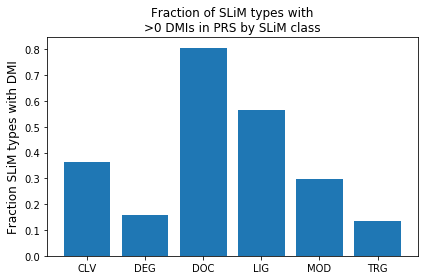

In [218]:
plt.bar(range(frac_DMI_df.shape[0]),frac_DMI_df['frac'],tick_label=frac_DMI_df.index)
plt.ylabel('Fraction SLiM types with DMI',fontsize=12)
plt.title('Fraction of SLiM types with\n>0 DMIs in PRS by SLiM class')
plt.tight_layout()
plt.savefig('fraction_SLiM_types_with_DMI.pdf')
plt.savefig('fraction_SLiM_types_with_DMI.png',dpi=300)
plt.show()

In [203]:
# plot the number of DMIs per SLiM type sorted from most to least
DMI_count_df.sort_values('DMICount',ascending=False,inplace=True)
DMI_count_df.head()

,Elm,SLiMClass,DMICount
139,LIG_LIR_Gen_1,LIG,67.0
176,LIG_Rb_LxCxE_1,LIG,42.0
0,CLV_C14_Caspase3-7,CLV,36.0
66,DOC_WW_Pin1_4,DOC,35.0
274,TRG_ER_FFAT_1,TRG,35.0


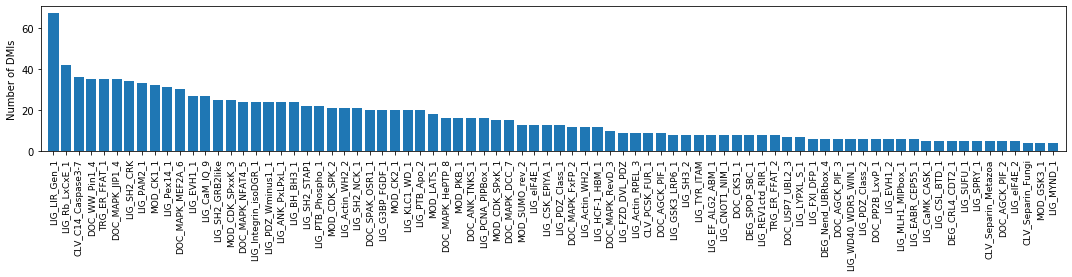

In [217]:
n = 80
plt.figure(figsize=(15,4))
plt.bar(range(n),DMI_count_df['DMICount'][:n])
plt.xticks(range(n),DMI_count_df['Elm'][:n],rotation=90,fontsize=9)
plt.xlim([-1,n])
plt.ylabel('Number of DMIs')
plt.tight_layout()
plt.savefig('number_of_DMIs_per_SLiMtype.pdf')
plt.savefig('number_of_DMIs_per_SLiMtype.png',dpi=300)
plt.show()